In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import csv
import seaborn as sns
from matplotlib import cm
from matplotlib.dates import MinuteLocator, DateFormatter
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, NullFormatter)

from datetime import timedelta

# 

import datetime as dt
from datetime import datetime

sns.set(rc={'figure.figsize':(11, 4)})
plt.rcParams["figure.figsize"] = (11,4)

# pd.set_option('notebook_repr_html',True)
%matplotlib inline
pd.set_option("display.max_rows",10)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
a = pd.Timestamp('2021-04-19 00:00')
a.minute

def time_to_period(x):
    return int(((2*(x.hour + x.minute/60)-1) % 48 )+ 1)


time_to_period(a)

def time_to_date(x):
    return x.date()

def time_to_periodstring(x):
    return 'Period_{:02d}'.format(time_to_period(x))

time_to_periodstring(a)

'Period_48'

## Import Data

In [2]:

def get_data(filename):
    rows = []
    with open(filename) as f_input:
        reader = csv.reader(f_input)
        for row in reader:
            if row:
                if row[0] == '300':
                    rows.append(row[1:50])
                    
    df = pd.DataFrame(rows)
    df.set_index(pd.to_datetime(df[0], format="%Y%m%d"), inplace=True)

    df.drop(columns=[0], inplace=True)
    df.index.set_names('DATE', inplace=True)
    df = df.astype('float')
    return df

In [3]:
def get_data(filename):
    
    dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')


    df = pd.read_csv(filename, parse_dates=[0], date_parser=dateparse)
    df['datetime'] = df.datetime_utc + timedelta(hours=10)
    df.drop('datetime_utc', axis=1, inplace=True)
    df = df.set_index('datetime')
    freq = pd.infer_freq(df.index)
    df = df.asfreq(freq)
    return df

## Get Powerpal Data


In [4]:

files = ['powerpal_data_00016633_20210415_20210714.csv',
        'powerpal_data_00016633_20210608_20210907.csv',
        ]

df_list = []
for filename in files:
    df_list.append(get_data(filename))

df = df_list[0]
for dfc in df_list[1:]:
    df = df.combine_first(dfc)
# df = pd.concat(df_list, ignore_index=False).sort_index()
df

,watt_hours,cost_dollars,is_peak
datetime,,,
2021-04-15 14:36:00,1.0,0.000815,False
2021-04-15 14:37:00,8.0,0.002371,False
2021-04-15 14:38:00,8.0,0.002371,False
2021-04-15 14:39:00,6.0,0.002060,False
2021-04-15 14:40:00,6.0,0.002060,False
...,...,...,...
2021-09-07 15:34:00,6.0,0.002060,False
2021-09-07 15:35:00,6.0,0.002060,False
2021-09-07 15:36:00,6.0,0.002060,False


In [5]:
df_30min = df.resample('30min').sum()
df_30min

,watt_hours,cost_dollars
datetime,,
2021-04-15 14:30:00,280.0,0.082098
2021-04-15 15:00:00,186.0,0.060549
2021-04-15 15:30:00,183.0,0.059927
2021-04-15 16:00:00,188.0,0.061794
2021-04-15 16:30:00,210.0,0.066149
...,...,...
2021-09-07 13:30:00,349.0,0.101923
2021-09-07 14:00:00,135.0,0.047795
2021-09-07 14:30:00,616.0,0.167561


In [8]:
df_30min.index.map(time_to_period)

Int64Index([29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
            ...
            22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
           dtype='int64', name='datetime', length=6963)

In [9]:
def to_columnwise(df):
    df['Period'] = df.index.map(time_to_period)
    df['Settlement_Date'] = df.index.map(time_to_date)
    df = df.reset_index()
    df = df.set_index(['Settlement_Date','Period'])
    df = df.watt_hours.unstack()
    df.columns = ['Period_{:02d}'.format(i+1) for i in range(48)]
    return df

In [10]:
to_columnwise(df_30min)

,Period_01,Period_02,Period_03,Period_04,Period_05,Period_06,Period_07,Period_08,Period_09,Period_10,...,Period_39,Period_40,Period_41,Period_42,Period_43,Period_44,Period_45,Period_46,Period_47,Period_48
Settlement_Date,,,,,,,,,,,,,,,,,,,,,
2021-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,179.0,170.0,170.0,161.0,161.0,129.0,112.0,100.0,87.0,NaN
2021-04-16,98.0,98.0,87.0,87.0,97.0,96.0,93.0,83.0,90.0,97.0,...,172.0,181.0,173.0,163.0,463.0,399.0,122.0,383.0,176.0,91.0
2021-04-17,96.0,92.0,83.0,89.0,98.0,95.0,84.0,82.0,93.0,92.0,...,278.0,263.0,142.0,137.0,214.0,127.0,114.0,88.0,85.0,90.0
2021-04-18,96.0,94.0,83.0,86.0,96.0,97.0,90.0,82.0,90.0,95.0,...,241.0,175.0,172.0,176.0,148.0,112.0,88.0,87.0,93.0,95.0
2021-04-19,96.0,86.0,85.0,95.0,95.0,91.0,82.0,86.0,96.0,95.0,...,188.0,270.0,265.0,134.0,131.0,123.0,106.0,100.0,90.0,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-03,102.0,108.0,153.0,122.0,95.0,108.0,104.0,93.0,92.0,100.0,...,226.0,219.0,190.0,193.0,169.0,170.0,124.0,130.0,120.0,92.0
2021-09-04,100.0,104.0,98.0,92.0,100.0,104.0,98.0,92.0,103.0,96.0,...,190.0,143.0,142.0,151.0,252.0,145.0,121.0,119.0,105.0,93.0
2021-09-05,106.0,107.0,96.0,96.0,106.0,104.0,95.0,97.0,107.0,102.0,...,305.0,361.0,266.0,300.0,302.0,138.0,110.0,100.0,92.0,97.0


In [6]:
df_5min = df.resample('5min').sum()
df_5min

,watt_hours,cost_dollars
datetime,,
2021-04-15 14:35:00,23.0,0.007617
2021-04-15 14:40:00,29.0,0.009988
2021-04-15 14:45:00,167.0,0.044207
2021-04-15 14:50:00,34.0,0.010921
2021-04-15 14:55:00,27.0,0.009366
...,...,...
2021-09-07 15:15:00,38.0,0.011854
2021-09-07 15:20:00,73.0,0.020565
2021-09-07 15:25:00,31.0,0.010299


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """Entry point for launching an IPython kernel.


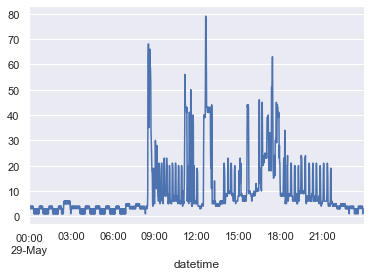

In [8]:
df['2021-05-29']['watt_hours'].plot()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


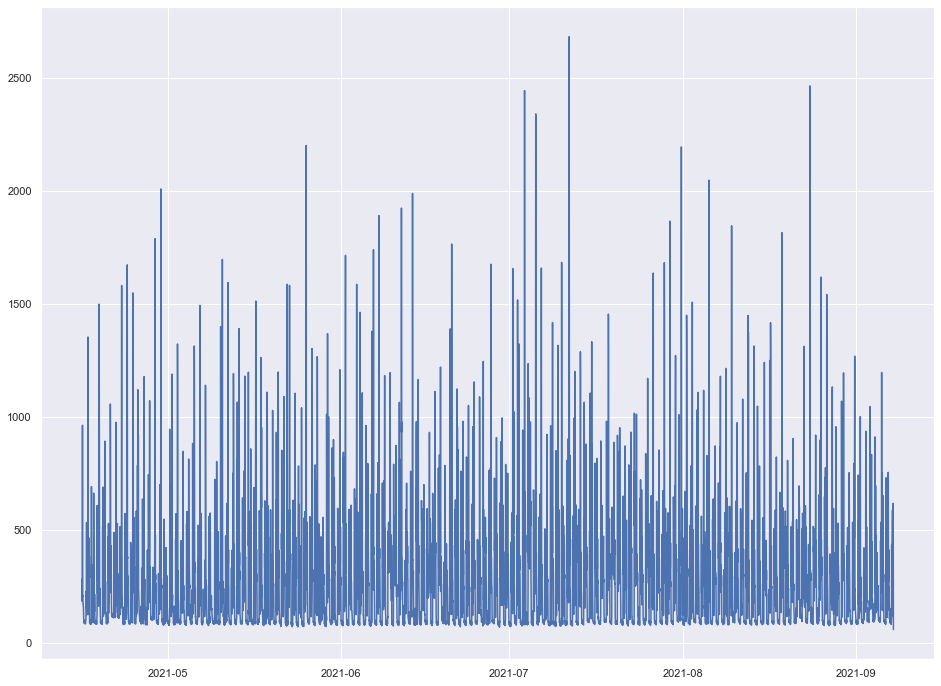

In [9]:
fig, ax = plt.subplots(figsize=(16,12))

x = df_30min.index
y = df_30min['watt_hours']

ax.plot(x,y)

In [12]:
def repeat_values(series):
    x = series.index
    freq = x.freq
    minutes = freq.n
    x = x.union(x + freq)
    x= x.values
    x = x.repeat(2)[1:-1]
    
    y = series.values
    y = y*(60/minutes)
    y = y.repeat(2)
    return x, y

# x, y = repeat_values(df.loc['2021-04-18'].watt_hours)

def plot_area(series):
    x, y = repeat_values(series)
    x = np.insert(x, 0, x[0])
    y = np.insert(y, 0, 0)
    
    x = np.append(x, x[-1])
    y = np.append(y, 0)
    
    

In [35]:
len(np.repeat(range(48+1),2)[1:-1])

96

In [29]:
(p[0].repeat(2))

array([ 76.,  76.,  73.,  73.,  77.,  77.,  75.,  75.,  76.,  76.,  73.,
        73.,  73.,  73.,  71.,  71.,  73.,  73.,  70.,  70.,  69.,  69.,
        68.,  68.,  73.,  73.,  71.,  71.,  81.,  81.,  88.,  88.,  85.,
        85.,  92.,  92.,  85.,  85.,  79.,  79.,  84.,  84.,  84.,  84.,
        85.,  85.,  82.,  82.,  80.,  80.,  80.,  80.,  83.,  83.,  82.,
        82.,  81.,  81.,  78.,  78.,  57.,  57.,  91.,  91.,  93.,  93.,
       120., 120., 120., 120., 110., 110., 111., 111., 119., 119., 121.,
       121., 111., 111., 140., 140., 125., 125., 103., 103.,  98.,  98.,
        83.,  83.,  81.,  81.,  80.,  80.,  77.,  77.])

In [7]:
x = df_30min.loc['2021-05-01':].watt_hours.index
freq = x.freq
minutes = freq.n
len(x.union(x + freq))

6225

In [8]:
len(x)

6224

In [54]:
x30, y30 = repeat_values(df_30min.loc['2021-05-01':].watt_hours)
x30

array(['2021-05-01T00:00:00.000000000', '2021-05-01T00:30:00.000000000',
       '2021-05-01T00:30:00.000000000', ...,
       '2021-09-07T15:30:00.000000000', '2021-09-07T15:30:00.000000000',
       '2021-09-07T16:00:00.000000000'], dtype='datetime64[ns]')

In [90]:
df_30min.loc[str(startdate):str(enddate)].watt_hours

datetime
2021-08-14 07:00:00      93.0
2021-08-14 07:30:00      92.0
2021-08-14 08:00:00      99.0
2021-08-14 08:30:00    1046.0
2021-08-14 09:00:00     329.0
                        ...  
2021-08-14 20:30:00     249.0
2021-08-14 21:00:00     257.0
2021-08-14 21:30:00     197.0
2021-08-14 22:00:00     125.0
2021-08-14 22:30:00     115.0
Freq: 30T, Name: watt_hours, Length: 32, dtype: float64

In [13]:
import matplotlib.cm as cm
cm.jet(10)

(0.0, 0.0, 0.67825311942959, 1.0)

In [15]:
colors = np.repeat(['red'],32)
colors

array(['red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red',
       'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red',
       'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red',
       'red', 'red', 'red', 'red', 'red'], dtype='<U3')

In [52]:
my_tuple_1 = (0.1, 0.5, 0.6, 1)
my_tuple_2 = (0.2, 0.8, 0.1, 1)
colors = (my_tuple_1, ) * 32
colors

((0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1),
 (0.1, 0.5, 0.6, 1))

In [64]:
colors = np.array(
    ([(0.04, 0.015, 0.02, 1.0)] * 1 + [(0.8, 0.5, 0.2, 1.0)] * 1) * 16, dtype=object
)
colors.shape

(32, 4)

In [61]:
colors = np.array([my_tuple_1, my_tuple_2] * 32
colors = [(0.04, 0.015, 0.02, 1.0), (0.8, 0.5, 0.2, 1.0)] * 32
                  
colors

[(0.04, 0.015, 0.02, 1.0),
 (0.8, 0.5, 0.2, 1.0),
 (0.04, 0.015, 0.02, 1.0),
 (0.8, 0.5, 0.2, 1.0),
 (0.04, 0.015, 0.02, 1.0),
 (0.8, 0.5, 0.2, 1.0),
 (0.04, 0.015, 0.02, 1.0),
 (0.8, 0.5, 0.2, 1.0),
 (0.04, 0.015, 0.02, 1.0),
 (0.8, 0.5, 0.2, 1.0),
 (0.04, 0.015, 0.02, 1.0),
 (0.8, 0.5, 0.2, 1.0),
 (0.04, 0.015, 0.02, 1.0),
 (0.8, 0.5, 0.2, 1.0),
 (0.04, 0.015, 0.02, 1.0),
 (0.8, 0.5, 0.2, 1.0),
 (0.04, 0.015, 0.02, 1.0),
 (0.8, 0.5, 0.2, 1.0),
 (0.04, 0.015, 0.02, 1.0),
 (0.8, 0.5, 0.2, 1.0),
 (0.04, 0.015, 0.02, 1.0),
 (0.8, 0.5, 0.2, 1.0),
 (0.04, 0.015, 0.02, 1.0),
 (0.8, 0.5, 0.2, 1.0),
 (0.04, 0.015, 0.02, 1.0),
 (0.8, 0.5, 0.2, 1.0),
 (0.04, 0.015, 0.02, 1.0),
 (0.8, 0.5, 0.2, 1.0),
 (0.04, 0.015, 0.02, 1.0),
 (0.8, 0.5, 0.2, 1.0),
 (0.04, 0.015, 0.02, 1.0),
 (0.8, 0.5, 0.2, 1.0),
 (0.04, 0.015, 0.02, 1.0),
 (0.8, 0.5, 0.2, 1.0),
 (0.04, 0.015, 0.02, 1.0),
 (0.8, 0.5, 0.2, 1.0),
 (0.04, 0.015, 0.02, 1.0),
 (0.8, 0.5, 0.2, 1.0),
 (0.04, 0.015, 0.02, 1.0),
 (0.8, 0.5, 0.2, 1.0),


In [58]:
np.array(([(0.04, 0.015, 0.02, 1.0)] * 2 + [(0.8, 0.5, 0.2, 1.0)] * 3) * 4)

array([[0.04 , 0.015, 0.02 , 1.   ],
       [0.04 , 0.015, 0.02 , 1.   ],
       [0.8  , 0.5  , 0.2  , 1.   ],
       [0.8  , 0.5  , 0.2  , 1.   ],
       [0.8  , 0.5  , 0.2  , 1.   ],
       [0.04 , 0.015, 0.02 , 1.   ],
       [0.04 , 0.015, 0.02 , 1.   ],
       [0.8  , 0.5  , 0.2  , 1.   ],
       [0.8  , 0.5  , 0.2  , 1.   ],
       [0.8  , 0.5  , 0.2  , 1.   ],
       [0.04 , 0.015, 0.02 , 1.   ],
       [0.04 , 0.015, 0.02 , 1.   ],
       [0.8  , 0.5  , 0.2  , 1.   ],
       [0.8  , 0.5  , 0.2  , 1.   ],
       [0.8  , 0.5  , 0.2  , 1.   ],
       [0.04 , 0.015, 0.02 , 1.   ],
       [0.04 , 0.015, 0.02 , 1.   ],
       [0.8  , 0.5  , 0.2  , 1.   ],
       [0.8  , 0.5  , 0.2  , 1.   ],
       [0.8  , 0.5  , 0.2  , 1.   ]])

In [44]:
((my_tuple_1,)*3, (my_tuple_2,)*3) * 4

(((0, 0.5, 0.6, 1), (0, 0.5, 0.6, 1), (0, 0.5, 0.6, 1)),
 ((0.2, 0.8, 0.1, 1), (0.2, 0.8, 0.1, 1), (0.2, 0.8, 0.1, 1)),
 ((0, 0.5, 0.6, 1), (0, 0.5, 0.6, 1), (0, 0.5, 0.6, 1)),
 ((0.2, 0.8, 0.1, 1), (0.2, 0.8, 0.1, 1), (0.2, 0.8, 0.1, 1)),
 ((0, 0.5, 0.6, 1), (0, 0.5, 0.6, 1), (0, 0.5, 0.6, 1)),
 ((0.2, 0.8, 0.1, 1), (0.2, 0.8, 0.1, 1), (0.2, 0.8, 0.1, 1)),
 ((0, 0.5, 0.6, 1), (0, 0.5, 0.6, 1), (0, 0.5, 0.6, 1)),
 ((0.2, 0.8, 0.1, 1), (0.2, 0.8, 0.1, 1), (0.2, 0.8, 0.1, 1)))

In [40]:
(my_tuple_1, my_tuple_2) * 4

((0, 0.5, 0.6, 1),
 (0.2, 0.8, 0.1, 1),
 (0, 0.5, 0.6, 1),
 (0.2, 0.8, 0.1, 1),
 (0, 0.5, 0.6, 1),
 (0.2, 0.8, 0.1, 1),
 (0, 0.5, 0.6, 1),
 (0.2, 0.8, 0.1, 1))

In [36]:
np.array([(my_tuple_1), (my_tuple_2)])

array([[0. , 0.5, 0.6, 1. ],
       [0.2, 0.8, 0.1, 1. ]])

In [45]:
colors = np.zeros(32)
colors[]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [37]:
colors = np.tile([(my_tuple_1), (my_tuple_2)], 16)
colors

array([[0. , 0.5, 0.6, 1. , 0. , 0.5, 0.6, 1. , 0. , 0.5, 0.6, 1. , 0. ,
        0.5, 0.6, 1. , 0. , 0.5, 0.6, 1. , 0. , 0.5, 0.6, 1. , 0. , 0.5,
        0.6, 1. , 0. , 0.5, 0.6, 1. , 0. , 0.5, 0.6, 1. , 0. , 0.5, 0.6,
        1. , 0. , 0.5, 0.6, 1. , 0. , 0.5, 0.6, 1. , 0. , 0.5, 0.6, 1. ,
        0. , 0.5, 0.6, 1. , 0. , 0.5, 0.6, 1. , 0. , 0.5, 0.6, 1. ],
       [0.2, 0.8, 0.1, 1. , 0.2, 0.8, 0.1, 1. , 0.2, 0.8, 0.1, 1. , 0.2,
        0.8, 0.1, 1. , 0.2, 0.8, 0.1, 1. , 0.2, 0.8, 0.1, 1. , 0.2, 0.8,
        0.1, 1. , 0.2, 0.8, 0.1, 1. , 0.2, 0.8, 0.1, 1. , 0.2, 0.8, 0.1,
        1. , 0.2, 0.8, 0.1, 1. , 0.2, 0.8, 0.1, 1. , 0.2, 0.8, 0.1, 1. ,
        0.2, 0.8, 0.1, 1. , 0.2, 0.8, 0.1, 1. , 0.2, 0.8, 0.1, 1. ]])

In [46]:
np.repeat([(my_tuple_1), my_tuple_2], 2, axis=0)

array([[0. , 0.5, 0.6, 1. ],
       [0. , 0.5, 0.6, 1. ],
       [0.2, 0.8, 0.1, 1. ],
       [0.2, 0.8, 0.1, 1. ]])

In [182]:
colors=np.tile((0, 128, 64,1),(16,1))
colors

array([[  0, 128,  64,   1],
       [  0, 128,  64,   1],
       [  0, 128,  64,   1],
       [  0, 128,  64,   1],
       [  0, 128,  64,   1],
       [  0, 128,  64,   1],
       [  0, 128,  64,   1],
       [  0, 128,  64,   1],
       [  0, 128,  64,   1],
       [  0, 128,  64,   1],
       [  0, 128,  64,   1],
       [  0, 128,  64,   1],
       [  0, 128,  64,   1],
       [  0, 128,  64,   1],
       [  0, 128,  64,   1],
       [  0, 128,  64,   1]])

In [25]:
colors = ([(0.04, 0.015, 0.02, 1.0)] * 6 + [(0.8, 0.5, 0.2, 1.0)] * 6) * 16
len(colors)

192

In [33]:
def plot_time(startdate, enddate):
    fig, ax = plt.subplots(figsize=(16,10))

    y = df_30min.loc[str(startdate):str(enddate)].watt_hours

    x30, y30 = repeat_values(df_30min.loc[str(startdate):str(enddate)].watt_hours)
#     ax.plot(x30,y30, color='k', linewidth = 1)
#     ax.fill_between(x30, y30, alpha=0.4, facecolor = 'grey')
#     print(len(y))
#     ax.bar(y.index, 2*y, width=pd.Timedelta(minutes=30)
# #            , edgecolor="none"
#            , align='edge'
#            , facecolor = "none"
# #            , color=colors
#            , alpha=0.75)

    y = df_5min.loc[str(startdate):str(enddate)].watt_hours
    x5, y5 = repeat_values(df_5min.loc[str(startdate):str(enddate)].watt_hours)
#     ax.plot(x5, y5, color='b', linewidth = 1)
    ax.bar(y.index, 12*y, width=pd.Timedelta(minutes=5)
           , edgecolor="none"
           , align='edge'
           , color=colors
#            , facecolor="grey"
           , alpha=0.75)
#     ax.fill_between(x5, y5, alpha=0.4, facecolor = 'b')

    x1, y1 = repeat_values(df.loc[str(startdate):str(enddate)].watt_hours)
    # ax.plot(x1, y1, color='r', linewidth = 1)



    x, y = repeat_values(df.loc['2021-05-01':].watt_hours)
    # ax.plot(x,y, linewidth = 1, color='green')
    # ax.fill_between(x, y, alpha=0.4, facecolor = 'red')

    # ax.fill_between(x, y, y>y30, alpha=0.4, facecolor = 'grey')


    # ax.set_xticks(ts)
    # ax.set_xticklabels(tl)

    majorLoc = MinuteLocator(byminute=np.arange(0,60,30))
    minorLoc = MinuteLocator(byminute=np.arange(0,60,5))
    ax.xaxis.set_major_locator(majorLoc)
    ax.xaxis.set_minor_locator(minorLoc)

    # ax.xaxis.set_major_locator(MultipleLocator(6))
    # ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_minor_formatter(NullFormatter())

    # ax.yaxis.set_minor_locator(MultipleLocator(60))

    # ax.yaxis.set_minor_formatter(NullFormatter())

    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
    # ax.xaxis.set_minor_formatter(DateFormatter('%H:%M'))
    ax.grid(b=True, which='minor', color='w', linewidth=0.5)

    # period_to_time(period, interval=30)

    ax.set_ylim(bottom=0)
    # ax.autoscale(axis='x', tight=True)
    plt.xticks(rotation = 90, ha='center');

    # )ax.set_xlim(pd.Timestamp('2021-04-19 14:00'), pd.Timestamp('2021-04-19 22:00')
    ax.set_xlim(startdate, enddate)
    # ax.set_xlim(192,204+6*6)
    
    return fig

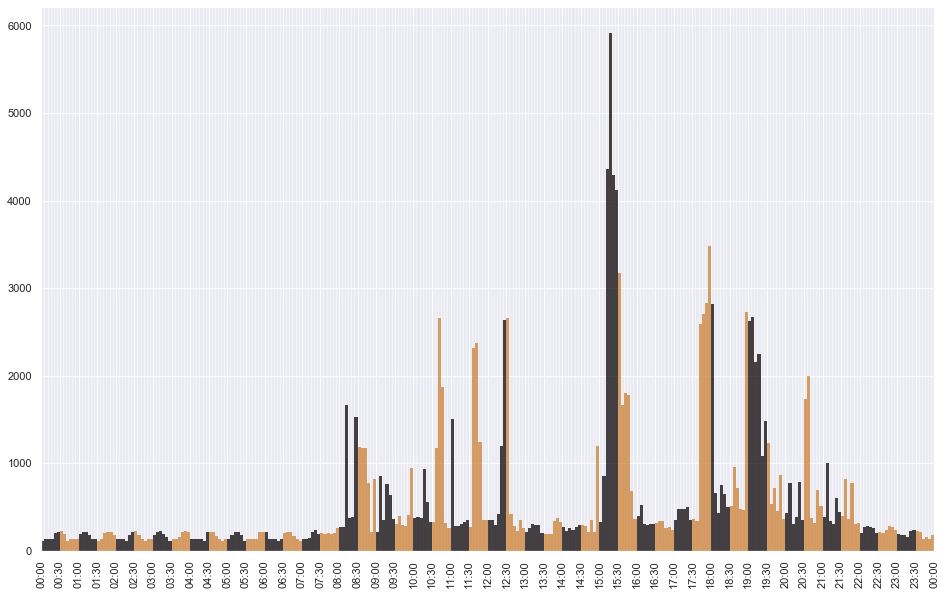

In [34]:
startdate = dt.datetime(2021,7,1,0)
enddate = dt.datetime(2021,7,2,0)
plot_time(startdate, enddate);

In [80]:
colorlist.shape

(32, 4)

ValueError: Invalid RGBA argument: array([[0.04, 0.015, 0.02, 1.0],
       [0.8, 0.5, 0.2, 1.0],
       [0.04, 0.015, 0.02, 1.0],
       [0.8, 0.5, 0.2, 1.0],
       [0.04, 0.015, 0.02, 1.0],
       [0.8, 0.5, 0.2, 1.0],
       [0.04, 0.015, 0.02, 1.0],
       [0.8, 0.5, 0.2, 1.0],
       [0.04, 0.015, 0.02, 1.0],
       [0.8, 0.5, 0.2, 1.0],
       [0.04, 0.015, 0.02, 1.0],
       [0.8, 0.5, 0.2, 1.0],
       [0.04, 0.015, 0.02, 1.0],
       [0.8, 0.5, 0.2, 1.0],
       [0.04, 0.015, 0.02, 1.0],
       [0.8, 0.5, 0.2, 1.0],
       [0.04, 0.015, 0.02, 1.0],
       [0.8, 0.5, 0.2, 1.0],
       [0.04, 0.015, 0.02, 1.0],
       [0.8, 0.5, 0.2, 1.0],
       [0.04, 0.015, 0.02, 1.0],
       [0.8, 0.5, 0.2, 1.0],
       [0.04, 0.015, 0.02, 1.0],
       [0.8, 0.5, 0.2, 1.0],
       [0.04, 0.015, 0.02, 1.0],
       [0.8, 0.5, 0.2, 1.0],
       [0.04, 0.015, 0.02, 1.0],
       [0.8, 0.5, 0.2, 1.0],
       [0.04, 0.015, 0.02, 1.0],
       [0.8, 0.5, 0.2, 1.0],
       [0.04, 0.015, 0.02, 1.0],
       [0.8, 0.5, 0.2, 1.0]], dtype=object)

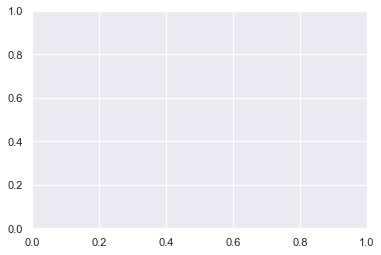

In [81]:
import numpy as np
import matplotlib.pyplot as plt

colorlist = np.array(
    ([(0.04, 0.015, 0.02, 1.0)] * 1 + [(0.8, 0.5, 0.2, 1.0)] * 1) * 16, dtype=object
)

fig, ax = plt.subplots()
y = np.ones(32)
x = np.linspace(1,32,32)
ax.bar(x, y, facecolor = colorlist)

In [181]:
def myfunc(i, n=6):
    return int(i / n % 2)

for i in range(48):
    print(i, myfunc(i, 6))

0 0
1 0
2 0
3 0
4 0
5 0
6 1
7 1
8 1
9 1
10 1
11 1
12 0
13 0
14 0
15 0
16 0
17 0
18 1
19 1
20 1
21 1
22 1
23 1
24 0
25 0
26 0
27 0
28 0
29 0
30 1
31 1
32 1
33 1
34 1
35 1
36 0
37 0
38 0
39 0
40 0
41 0
42 1
43 1
44 1
45 1
46 1
47 1


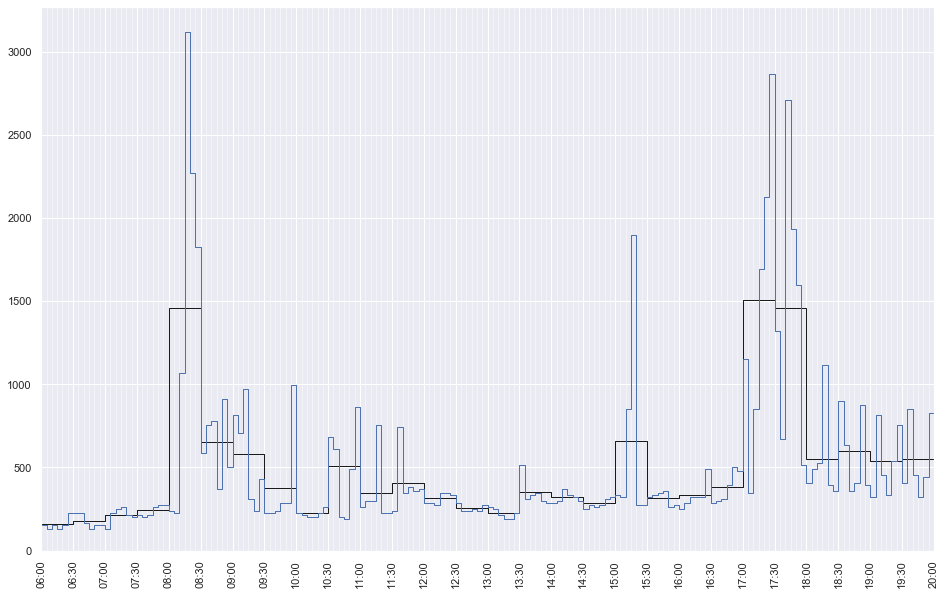

In [72]:
startdate = dt.datetime(2021,9,6,6)
enddate = dt.datetime(2021,9,6,20)
plot_time(startdate, enddate);

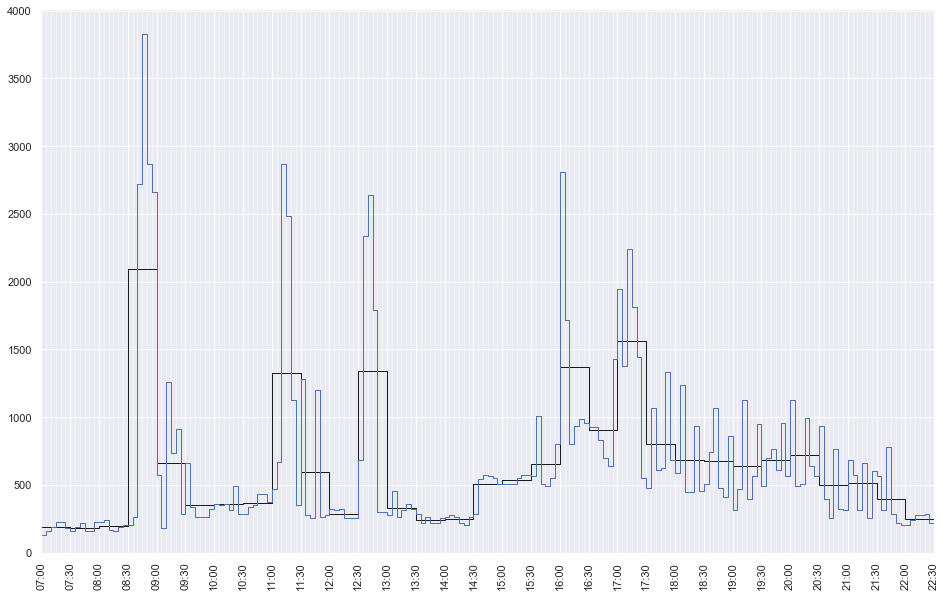

In [81]:
startdate = dt.datetime(2021,8,14,7)
enddate = dt.datetime(2021,8,14,22,30)
plot_time(startdate, enddate);

## Area Charts

In [11]:
df_30min

,watt_hours,cost_dollars,Period,Settlement_Date
datetime,,,,
2021-04-15 14:30:00,280.0,0.082098,29,2021-04-15
2021-04-15 15:00:00,186.0,0.060549,30,2021-04-15
2021-04-15 15:30:00,183.0,0.059927,31,2021-04-15
2021-04-15 16:00:00,188.0,0.061794,32,2021-04-15
2021-04-15 16:30:00,210.0,0.066149,33,2021-04-15
...,...,...,...,...
2021-09-07 13:30:00,349.0,0.101923,27,2021-09-07
2021-09-07 14:00:00,135.0,0.047795,28,2021-09-07
2021-09-07 14:30:00,616.0,0.167561,29,2021-09-07


In [14]:
dfx = to_columnwise(df_30min)

In [45]:
def plot_profile(df):
#     percs = [0, 5, 25, 50, 75, 95, 100]
    percs = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    perclist = []
    for perc in percs:
        a = df.quantile(perc/100.)
        perclist.append(a.values)
    
    
    return perclist

p = plot_profile(dfx)

In [93]:
ts = np.arange(1, 48, step=2)+1
def period_to_time(period, interval=30):
    mod = 60 // interval
    return dt.time(((period+0) //mod)% 24,((period+0) % mod)*interval).strftime("%H:%M")

# ts = np.arange(0, 48, step=6)+6
# ts = np.arange(0, 48, step=6)+2

# ts = np.arange(0, 289, step=6)
tl = [period_to_time(t, 30) for t in ts]
print(ts)
print(tl)

[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48]
['01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00', '00:00']


In [104]:
colorlist = [[0.05,0.05,.05],[0.2, 0.2, 0.2],[0.4, 0.4, 0.4],[0.6, 0.6, 0.6],[0.7, 0.7, 0.7]]
len(colorlist)

5

(0, 47)

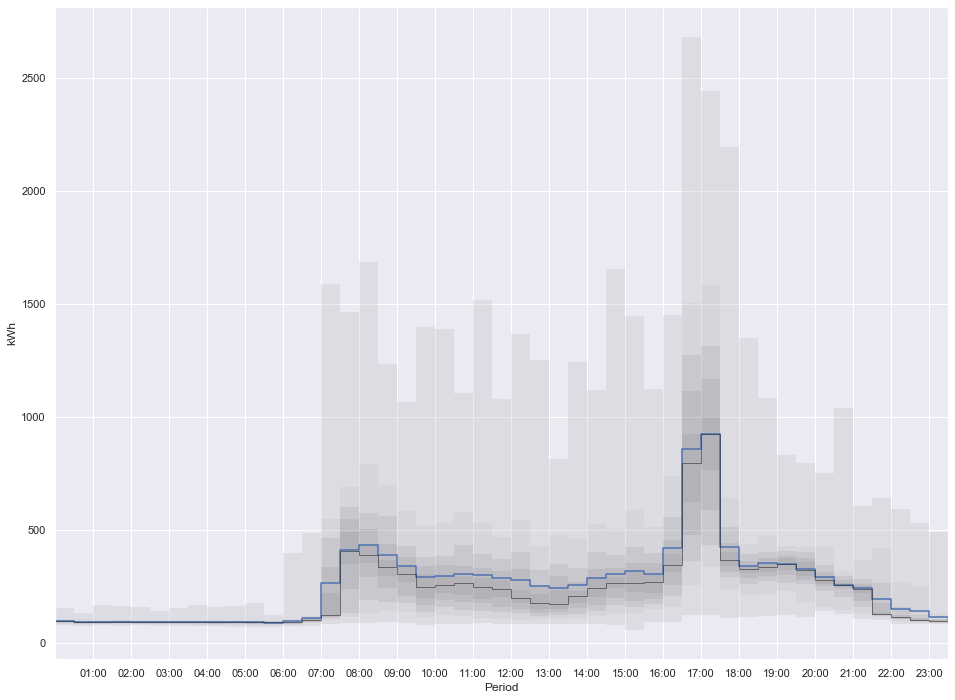

In [106]:
fig, ax = plt.subplots(figsize=(16,12))

x = np.repeat(range(48+1),2)[1:-1]

# Plot mean
y = dfx.mean()
# (p[0].repeat(2))
line0, = ax.plot(x, y.values.repeat(2))

# Plot Median
y = p[5].repeat(2)
line3, = ax.plot(x, y, color = 'k', lw=0.5)


# Plot shaded area
x = np.concatenate((x, x[::-1]))
x


# 0th percentile
for i in range(len(p)-1):
    j =abs(int(5.5-(i+1)))
    y = np.concatenate((p[i].repeat(2), p[i+1].repeat(2)[::-1]))
    line00, = ax.fill(x, y, alpha = 0.25, facecolor = colorlist[j], edgecolor='none', lw=0.5)

# y = np.concatenate((p[1].repeat(2), p[2].repeat(2)[::-1]))
# line10, = ax.fill(x, y, alpha = 0.25, facecolor = [0.6, 0.6, 0.6], lw=0.5)

# y = np.concatenate((p[2].repeat(2), p[3].repeat(2)[::-1]))
# line20, = ax.fill(x, y, alpha = 0.25, facecolor = [0.5, 0.5, 0.5], lw=0.5)

# y = np.concatenate((p[3].repeat(2), p[4].repeat(2)[::-1]))
# line30, = ax.fill(x, y, alpha = 0.25, facecolor = [0.4, 0.4, 0.4], lw=0.5)

# y = np.concatenate((p[4].repeat(2), p[5].repeat(2)[::-1]))
# line40, = ax.fill(x, y, alpha = 0.25, facecolor = [0.3, 0.3, 0.3], lw=0.5)

# y = np.concatenate((p[5].repeat(2), p[6].repeat(2)[::-1]))
# line8, = ax.fill(x, y, alpha = 0.25, facecolor = [0.75, 0.75, 0.75], lw=0.5)

# y = np.concatenate((p[6].repeat(2), p[7].repeat(2)[::-1]))
# line9, = ax.fill(x, y, alpha = 0.25, facecolor = [0.75, 0.75, 0.75], lw=0.5)

# y = np.concatenate((p[7].repeat(2), p[8].repeat(2)[::-1]))
# line10, = ax.fill(x, y, alpha = 0.25, facecolor = [0.75, 0.75, 0.75], lw=0.5)

# ax.legend((line0, line1, line2, line3, line4, line5, line6, line7, line8), ('Mean','Max', 'Rolling Peak Day','Median', '50-75th per', '75-95th per', '95th-Max per'))

# ax.grid('On')
ax.set_xlim([1,48])
# ax.set_ylim(bottom=0)
# ax.set_ylim([0,1])
ax.set_ylabel('kWh')
ax.set_xlabel('Period')


# for t in nt:
#     ax.axvspan(t[0], t[1], alpha=0.1, facecolor = '0.65', edgecolor = '0.65')

# ax.axvline(34, color='r',linestyle = ':')
# ax.axvline(42, color='r',linestyle = ':')


# mv = dplot['Average'].iloc[14:44].mean()
# xs = np.arange(14,46)
# ys = np.ones(32)*mv
# ax.plot(xs,ys)

# djm.plot(ax=ax, colormap='spring')

# drm.plot(ax=ax, colormap='binary')

ax.set_xticks(ts);
ax.set_xticklabels([period_to_time(t) for t in ts])
ax.xaxis.grid('On')
ax.set_xlim([0,47])
# print mv
# ax.axhline(mv)

# plot_profile(dfx)

Text(0.5, 0, 'Period')

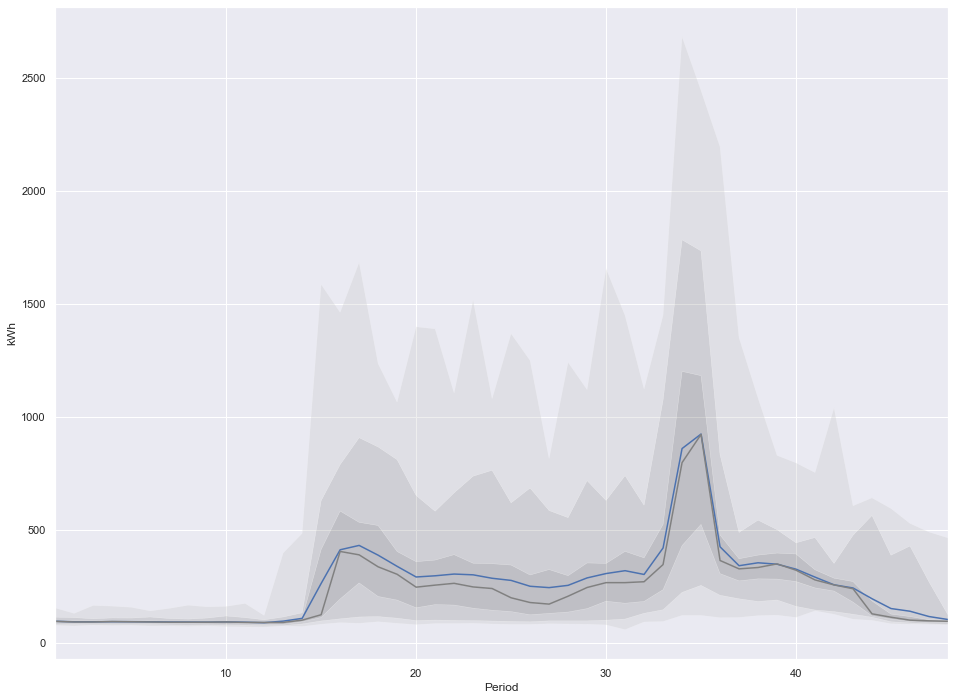

In [21]:
fig, ax = plt.subplots(figsize=(16,12))

# def plot_profile(ax, dfx, month, daytype):

x = np.arange(48) + 1

x = np.repeat(range(48+1),2)[1:-1]
# x = dplot.index

# dcf.T.plot(ax = ax, legend=None, colormap='Purples')

# Plot mean
y = dfx.mean()
line0, = ax.plot(x, y)


# # Plot Max
# y = dplot['Maximum']
# line1, = ax.plot(x, y)

# # Plot Rolling 7.5hh avg
# y = dplot['RollingCons']
# line2, = ax.plot(x, y)

# Plot Median
y = p[3]
line3, = ax.plot(x, y, color = [0.5,0.5,0.5])


# Plot shaded area
x = np.concatenate((x, x[::-1]))
x


# 0th percentile
y = np.concatenate((p[0], p[1][::-1]))
line4, = ax.fill(x, y, alpha = 0.25, facecolor = [0.75, 0.75, 0.75], lw=0.5)

y = np.concatenate((p[1], p[2][::-1]))
line4, = ax.fill(x, y, alpha = 0.25, facecolor = [0.5, 0.5, 0.5], lw=0.5)

y = np.concatenate((p[2], p[3][::-1]))
line5, = ax.fill(x, y, alpha = 0.25, facecolor = [0.25, 0.25, 0.25], lw=0.5)

y = np.concatenate((p[3], p[4][::-1]))
line6, = ax.fill(x, y, alpha = 0.25, facecolor = [0.25, 0.25, 0.25], lw=0.5)

y = np.concatenate((p[4], p[5][::-1]))
line7, = ax.fill(x, y, alpha = 0.25, facecolor = [0.5, 0.5, 0.5], lw=0.5)

y = np.concatenate((p[5], p[6][::-1]))
line8, = ax.fill(x, y, alpha = 0.25, facecolor = [0.75, 0.75, 0.75], lw=0.5)

# ax.legend((line0, line1, line2, line3, line4, line5, line6, line7, line8), ('Mean','Max', 'Rolling Peak Day','Median', '50-75th per', '75-95th per', '95th-Max per'))

# ax.grid('On')
ax.set_xlim([1,48])
# ax.set_ylim(bottom=0)
# ax.set_ylim([0,1])
ax.set_ylabel('kWh')
ax.set_xlabel('Period')


# for t in nt:
#     ax.axvspan(t[0], t[1], alpha=0.1, facecolor = '0.65', edgecolor = '0.65')

# ax.axvline(34, color='r',linestyle = ':')
# ax.axvline(42, color='r',linestyle = ':')


# mv = dplot['Average'].iloc[14:44].mean()
# xs = np.arange(14,46)
# ys = np.ones(32)*mv
# ax.plot(xs,ys)

# djm.plot(ax=ax, colormap='spring')

# drm.plot(ax=ax, colormap='binary')

# ax.set_xticks(ts)
# ax.set_xticklabels([period_to_time(t) for t in ts])
# ax.xaxis.grid('On')

# print mv
# ax.axhline(mv)

# plot_profile(dfx)

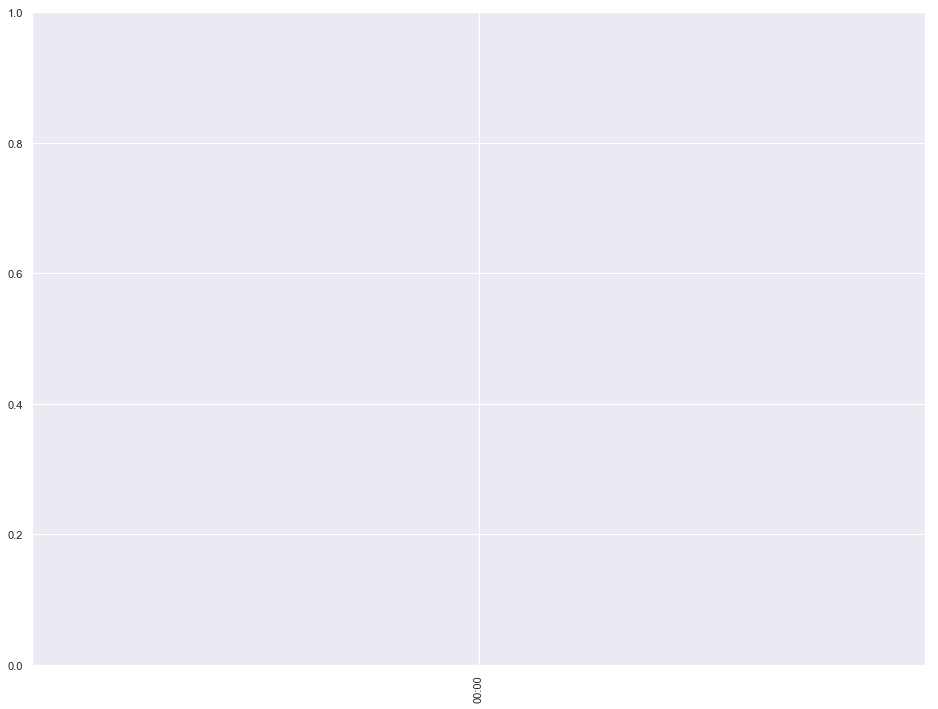

In [25]:
from matplotlib.dates import MinuteLocator, DateFormatter
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, NullFormatter)

fig, ax = plt.subplots(figsize=(16,12))

plot_area(df_30min.loc['2021-05-01':].watt_hours)
# x30, y30 = repeat_values(df_30min.loc['2021-05-01':].watt_hours)
# ax.plot(x30,y30, color='k', linewidth = 1)
# ax.fill_between(x, y, alpha=0.4, facecolor = 'grey')

# x5, y5 = repeat_values(df_5min.loc['2021-05-01':].watt_hours)
# ax.plot(xl, y5, color='b', linewidth = 1)

# x5, y5 = repeat_values(df_5min.loc['2021-05-01':].watt_hours)
# ax.plot(xl, y5, color='r', linewidth = 1)



x, y = repeat_values(df.loc['2021-05-01':].watt_hours)
# ax.plot(x,y, linewidth = 1, color='green')
# ax.fill_between(x, y, alpha=0.4, facecolor = 'red')

# ax.fill_between(x, y, y>y30, alpha=0.4, facecolor = 'grey')


ax.set_xticks(ts)
ax.set_xticklabels(tl)

# majorLoc = MinuteLocator(byminute=np.arange(0,60,30))
# minorLoc = MinuteLocator(byminute=np.arange(0,60,5))
# ax.xaxis.set_major_locator(majorLoc)
# ax.xaxis.set_minor_locator(minorLoc)

# ax.xaxis.set_major_locator(MultipleLocator(6))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_minor_formatter(NullFormatter())

ax.yaxis.set_minor_locator(MultipleLocator(60))

ax.yaxis.set_minor_formatter(NullFormatter())

# ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
# ax.xaxis.set_minor_formatter(DateFormatter('%H:%M'))
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

period_to_time(period, interval=30)

ax.set_ylim(bottom=0)
ax.autoscale(axis='x', tight=True)
plt.xticks(rotation = 90, ha='center');

# )ax.set_xlim(pd.Timestamp('2021-04-19 14:00'), pd.Timestamp('2021-04-19 22:00')
# ax.set_xlim(192,204+6*6)

In [27]:
df_5min['2021-04-19 17:00':'2021-04-19 17:25']

,watt_hours,cost_dollars,is_peak
datetime,,,
2021-04-19 17:00:00,40,0.012165,False
2021-04-19 17:05:00,41,0.012165,False
2021-04-19 17:10:00,115,0.030830,False
2021-04-19 17:15:00,86,0.023675,False
2021-04-19 17:20:00,43,0.012788,False
2021-04-19 17:25:00,298,0.076559,False


In [28]:
x = df_30min.loc['2021-04-18'].index.values
# x = x.repeat(2)[1:]
print(x[-1]+ np.timedelta64(30, 'm'))

2021-04-19T00:00:00.000000000


In [29]:
data_ary = df_30min.loc['2021-04-18'].watt_hours.values
print(len(data_ary))
y = data_ary.repeat(2)
print(len(y))

48
96


In [19]:
def transpose_df(df):
    dff = df.copy()
    dff['Interval'] = df.index

,watt_hours,cost_dollars
datetime,,
2021-04-15 14:30:00,280.0,0.082098
2021-04-15 15:00:00,186.0,0.060549
2021-04-15 15:30:00,183.0,0.059927
2021-04-15 16:00:00,188.0,0.061794
2021-04-15 16:30:00,210.0,0.066149
...,...,...
2021-09-07 13:30:00,349.0,0.101923
2021-09-07 14:00:00,135.0,0.047795
2021-09-07 14:30:00,616.0,0.167561


In [11]:
df_30min

,watt_hours,cost_dollars
datetime,,
2021-04-15 14:30:00,280.0,0.082098
2021-04-15 15:00:00,186.0,0.060549
2021-04-15 15:30:00,183.0,0.059927
2021-04-15 16:00:00,188.0,0.061794
2021-04-15 16:30:00,210.0,0.066149
...,...,...
2021-09-07 13:30:00,349.0,0.101923
2021-09-07 14:00:00,135.0,0.047795
2021-09-07 14:30:00,616.0,0.167561


In [80]:
ts = np.arange(0, 48, step=6)+6
ts = np.arange(0, 48, step=6)+2

ts = np.arange(0, 48, step=6)+2
def period_to_time(period):
    return dt.time((period //2) % 24,(period % 2)*30).strftime("%H:%M")
tl = [period_to_time(t) for t in ts]

# (47 / 2)

In [34]:
period = 5
(period //2) % 24
(period % 2)*30

30

In [35]:
def period_to_time(period):
    return dt.time((period //2) % 24,(period % 2)*30).strftime("%H:%M")

[period_to_time(t) for t in ts]

['01:00', '04:00', '07:00', '10:00', '13:00', '16:00', '19:00', '22:00']

In [38]:
df[-31:]

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
DATE,,,,,,,,,,,,,,,,,,,,,
2021-02-21,0.100,0.088,0.100,0.088,0.100,0.100,0.100,0.088,0.100,0.088,...,0.213,0.175,0.163,0.175,0.113,0.088,0.088,0.075,0.088,0.075
2021-02-22,0.075,0.088,0.088,0.075,0.075,0.075,0.088,0.088,0.063,0.075,...,0.163,0.163,0.163,0.150,0.113,0.088,0.075,0.075,0.088,0.088
2021-02-23,0.088,0.075,0.075,0.088,0.088,0.088,0.075,0.075,0.075,0.088,...,0.175,0.138,0.138,0.125,0.113,0.088,0.075,0.075,0.100,0.088
2021-02-24,0.075,0.075,0.088,0.088,0.088,0.063,0.088,0.088,0.075,0.150,...,0.138,0.150,0.125,0.125,0.088,0.088,0.088,0.088,0.075,0.125
2021-02-25,0.125,0.113,0.075,0.075,0.100,0.088,0.075,0.075,0.075,0.088,...,0.138,0.150,0.138,0.125,0.075,0.088,0.088,0.088,0.063,0.150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-19,0.088,0.100,0.100,0.100,0.088,0.088,0.100,0.100,0.088,0.088,...,0.225,0.213,0.188,0.188,0.138,0.125,0.100,0.100,0.100,0.100
2021-03-20,0.088,0.100,0.113,0.088,0.100,0.088,0.088,0.088,0.088,0.088,...,0.200,0.150,0.138,0.125,0.113,0.100,0.088,0.075,0.075,0.088
2021-03-21,0.088,0.088,0.075,0.075,0.075,0.088,0.088,0.075,0.075,0.088,...,0.263,0.188,0.175,0.450,0.288,0.263,0.288,0.100,0.088,0.075


In [43]:
df.sample(3)

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
DATE,,,,,,,,,,,,,,,,,,,,,
2021-01-29,0.088,0.100,0.100,0.100,0.088,0.088,0.100,0.100,0.100,0.088,...,0.225,0.213,0.213,0.175,0.113,0.113,0.100,0.100,0.088,0.088
2020-05-12,0.075,0.063,0.075,0.075,0.075,0.063,0.075,0.088,0.063,0.063,...,0.375,0.275,0.613,0.238,0.238,0.213,0.100,0.075,0.075,0.075
2019-09-15,0.075,0.075,0.063,0.063,0.063,0.075,0.063,0.063,0.075,0.063,...,0.150,0.150,0.200,0.175,0.163,0.150,0.113,0.100,0.100,0.100


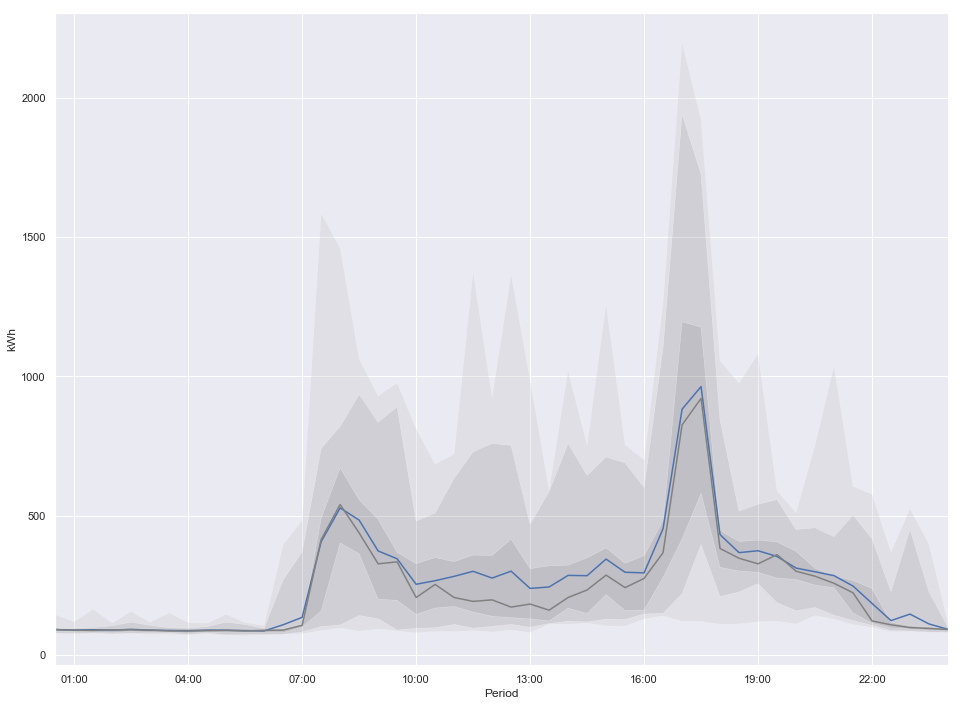

In [73]:
def create_distplot(df):
    fig, ax = plt.subplots(figsize=(16,12))

    p = plot_profile(df)
    x = np.arange(48) + 1

    # Plot mean
    line0, = ax.plot(x, df.mean())  
#     ax.plot(x, df.sample(3).T)
    
    # Plot Median
    line3, = ax.plot(x, p[3], color = [0.5,0.5,0.5])

    # Plot shaded area
    x = np.concatenate((x, x[::-1]))

    # 0th percentile
    y = np.concatenate((p[0], p[1][::-1]))
    line4, = ax.fill(x, y, alpha = 0.25, facecolor = [0.75, 0.75, 0.75], lw=0.5)

    y = np.concatenate((p[1], p[2][::-1]))
    line4, = ax.fill(x, y, alpha = 0.25, facecolor = [0.5, 0.5, 0.5], lw=0.5)

    y = np.concatenate((p[2], p[3][::-1]))
    line5, = ax.fill(x, y, alpha = 0.25, facecolor = [0.25, 0.25, 0.25], lw=0.5)

    y = np.concatenate((p[3], p[4][::-1]))
    line6, = ax.fill(x, y, alpha = 0.25, facecolor = [0.25, 0.25, 0.25], lw=0.5)

    y = np.concatenate((p[4], p[5][::-1]))
    line7, = ax.fill(x, y, alpha = 0.25, facecolor = [0.5, 0.5, 0.5], lw=0.5)

    y = np.concatenate((p[5], p[6][::-1]))
    line8, = ax.fill(x, y, alpha = 0.25, facecolor = [0.75, 0.75, 0.75], lw=0.5)

    # ax.legend((line0, line1, line2, line3, line4, line5, line6, line7, line8), ('Mean','Max', 'Rolling Peak Day','Median', '50-75th per', '75-95th per', '95th-Max per'))

    # ax.grid('On')
    ax.set_xlim([1,48])
    # ax.set_ylim(bottom=0)
    # ax.set_ylim([0,1])
    ax.set_ylabel('kWh')
    ax.set_xlabel('Period')


    # for t in nt:
    #     ax.axvspan(t[0], t[1], alpha=0.1, facecolor = '0.65', edgecolor = '0.65')

    # ax.axvline(34, color='r',linestyle = ':')
    # ax.axvline(42, color='r',linestyle = ':')


    # mv = dplot['Average'].iloc[14:44].mean()
    # xs = np.arange(14,46)
    # ys = np.ones(32)*mv
    # ax.plot(xs,ys)

    # djm.plot(ax=ax, colormap='spring')

    # drm.plot(ax=ax, colormap='binary')

    ax.set_xticks(ts)
    ax.set_xticklabels([period_to_time(t) for t in ts])
    ax.xaxis.grid('On')

    # print mv
    # ax.axhline(mv)

create_distplot(df[-31:])

In [ ]:

# FROM https://stackoverflow.com/questions/53071379/using-percentiles-of-a-timeseries-to-set-colour-gradient-in-pythons-matplotlib
n = 11
colormap = cm.Blues
percentiles = np.linspace(0,100,n)

SDist = np.zeros((48,n))
for i in range(n):
    for t in range(48):
        SDist[t, i] = np.percentile(df.iloc[:,t], percentiles[i])
        
half = int((n-1)/2)


fig, ax = plt.subplots(figsize=(16,12))

ax.plot(range(48), df.mean(axis=0), color='k')
ax.plot(range(48), SDist[:,half], color='g')

for i in range(half):
    ax.fill_between(range(48), SDist[:,i], SDist[:,-(i+1)], color=colormap(i/half), alpha = 0.5)
    
# ax.set_ylim([0, 0.5])

In [ ]:
period_to_time(16)
period_to_time(34)

In [ ]:
period = 6
(period //2) % 24,(period % 2)*30

In [ ]:
fig = plt.Figure(figsize=(16,10))
x = df.columns
# y1=df.loc['2018-06-29']
# y2=df.loc['2018-06-30']
# y3=df.loc['2018-07-01']

y1=df.loc['2021-03-20']
y2=df.loc['2021-03-21']
y3=df.loc['2021-03-22']

ax1 = plt.subplot(3,1,1)
ax1.bar(x, y1)

ax2 = plt.subplot(3,1,2)
ax2.bar(x, y2)

ax3 = plt.subplot(3,1,3)
ax3.bar(x, y3)

In [ ]:
df.sample(1).values
# df.loc['2021-03-10']

In [ ]:
startdate = dt.date(2021,5,1)
enddate = dt.date(2021,5,30)


def plot_month(ax, df):

    for i, (name, row) in enumerate(df.iterrows()):
        d = '1'#pd.to_datetime(name[3]).strftime('%d')
#         t = row['MaxTemp']   
        color = 'grey'        
        ax.plot(row, color = color, linewidth = 0.5, alpha = 0.2)

    avg = df.mean(axis=0)
    ax.plot(avg, 'k', linewidth = 2)
    ax.set_xticks(ts)
    ax.set_xticklabels(tl)
    ax.xaxis.grid('On')
#     ax.legend(loc='best', facecolor='k', framealpha=0.2, edgecolor ='k', frameon=True)
    ax.set_xlim([0,47])
    
    return avg

fig, ax = plt.subplots(figsize=(12,8))
plot_month(ax, df.loc[str(startdate):str(enddate)]);
# y1=df.loc['2021-03-10']
# y2=df.loc['2021-03-22']
# y3=df.loc['2021-03-23']
y1 = df.loc[str(startdate):str(enddate)].sample(1)
ax.plot(y1.T, 'r')
ax.set_xlim([1,47])
ax.set_ylabel('Energy (kWh per half hour)')

In [ ]:
def plot_hm(df):
    ytl = df.index.strftime('%a %d-%b')
#     cmap = sns.color_palette("YlOrRd",100)
    cmap = sns.color_palette("rocket_r", 40)
    labels = df.applymap(lambda v: '{:3.1f}'.format(v) if v > 1.0 else "")
    sns.heatmap(df, cmap=cmap, yticklabels=ytl, linewidth=0.01
               ,linecolor="grey"
#                ,annot = labels, annot_kws={'fontsize':10}, fmt = ''
               )#, vmin=0, vmax=3.5)
    axes = fig.gca()
#     axes.yaxis.grid(False)
    axes.set_xticks(ts);
    axes.set_xticklabels([period_to_time(t) for t in ts]);

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
plot_hm(df[(df.index >='2021-01-01') & (df.index <'2021-04-01')])

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
plot_hm(df[(df.index >='2020-01-01') & (df.index <'2020-02-01')])

In [ ]:
df.sum().sum()
dcf.sum().sum()

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
x = df.columns

# y1=df.loc['2018-06-29']
# y2=df.loc['2018-06-30']
# y3=df.loc['2018-07-13']

# y1=df.loc['2018-12-24']
# y2=df.loc['2018-12-26']
# y3=df.loc['2018-12-01']

y1=df.loc['2021-03-21']
# y2=df.loc['2021-03-22']
# y3=df.loc['2021-03-23']



ax.plot(x, y1)
# ax.plot(x, y2)
# ax.plot(x, y3)
ax.plot(x, df.loc['2021-03-01':'2021-03-31'].mean(axis=0), 'k')
# ax.bar(x, [y1, y2, y3])
print(x)

In [ ]:
df[df.index >'2021-01-07'].applymap(lambda v: '{:3.1f}'.format(v) if v > 0.2 else "")

In [ ]:
df.mean().plot(legend = 'Cropley')
# df.max().plot(legend = 'Cropley')
# df.std().plot()
dcf.mean().plot()
ax = plt.gca()
ax.legend(['C','E'])
# ax.plot(df.loc['2019-06-28'])

In [ ]:
df.T.plot(legend=False)

## Daily

In [ ]:
df_daily = df.sum(axis=1).to_frame('Cons')
dcf_daily = dcf.sum(axis=1).to_frame('Cons')

In [ ]:
bins = np.arange(0,25,0.5)
bins = np.linspace(0,20,50);
df_daily.plot(kind='hist', bins=bins, normed = True)
dcf_daily.plot(kind='hist', bins=bins, normed = True)

In [ ]:
x1 = df_daily['Cons']
bins = np.linspace(0,20,50);
fix, ax = plt.subplots(figsize=(10,5));

ax.hist(x1, bins, histtype='stepfilled', alpha=0.5, normed=True);

x2 = dcf_daily['Cons']
ax.hist(x2, bins, histtype='stepfilled', alpha=0.5, normed=True);

In [ ]:
df_daily.sort_values(by='Cons', ascending=False)

In [ ]:
ax = df_daily.plot()
ax2 = dcf_daily.plot()
ax3 = df_daily.rolling(365).sum().plot()
dcf_daily.rolling(365).sum().plot(ax =ax3)
ax3.set_ylim(bottom = 0)

In [ ]:
fig, ax = plt.subplots()
df_daily.groupby(df_daily.index.month).mean().plot(ax=ax, kind='bar')
# dcf_daily.groupby(dcf_daily.index.month).sum().plot(ax=ax, kind='bar')
ax.set_ylim(bottom=0)

In [ ]:
df_daily.groupby(df_daily.index.month).mean().sum()

In [ ]:
fig, ax = plt.subplots()
df_daily[df_daily.index.year == 2020].groupby(df_daily[df_daily.index.year == 2020].index.month).sum().plot(ax=ax, kind='bar')
# df_daily[df_daily.index.year == 2021].groupby(df_daily[df_daily.index.year == 2021].index.month).sum().plot(ax=ax, kind='bar')
# df_daily[df_daily.index.year == 2019].groupby(df_daily[df_daily.index.year == 2019].index.month).sum().plot(ax=ax, kind='bar')

# Older Stuff

In [ ]:
header = ['RecordIndicator','IntervalDate']+['IntervalValue%02d'% (x+1) for x in range(48)]+['QualityMethod','ReasonCode','ReasonDescription','UpdateDateTime','MSATSLoadDateTime']

In [ ]:
filename = '62038160906_20150814_20170814_lastrowremoved.txt'
if os.path.isfile(filename):
#     dateparse = lambda dates: [pd.datetime.strptime(d, '%d/%m/%Y %H:%M:%S') for d in dates]
    dateparse = lambda dates: [pd.datetime.strptime(d, '%Y%m%d') for d in dates]
    
    df = pd.read_csv(filename, 
                       names=header, 
                       skiprows=2, 
                       parse_dates=[1], 
                       date_parser=dateparse)
    print "loaded ", filename, " successfully"
else:
    print "File ", filename, " not found"
df.dropna(axis=1, how = 'all', inplace=True)
df.drop(['RecordIndicator'],1, inplace=True)
df = df[['IntervalDate','QualityMethod','UpdateDateTime']+['IntervalValue%02d' % (x+1) for x in range(48)]]
df.set_index('IntervalDate', inplace=True)
# data.index = data['IntervalDate']
# del data['IntervalDate']
df

In [ ]:
df.reset_index()

In [ ]:
df_hh = pd.melt(df.reset_index(), id_vars=['IntervalDate','QualityMethod'], 
        value_vars=['IntervalValue%02d' % (x+1) for x in range(48)],
       var_name = 'Interval', value_name = 'ReadValue')
df_hh['Interval'] = df_hh['Interval'].str[13:].astype(int)
df_hh['IntervalDate'] = df_hh.apply(lambda row: row.IntervalDate + pd.Timedelta(minutes = 30*(row.Interval-1)), axis=1)
df_hh = df_hh.set_index(['IntervalDate'])
# df_hh.drop('Interval')
df_hh.sort_index(inplace=True)
df_hh

In [ ]:
df_hh.plot(y = 'ReadValue')

In [ ]:
df[df.index.dayofweek == 6]

In [ ]:
#data['weekday'] = data.index.weekday
df['weekday'] = data['weekday'].apply(lambda x: 1 if x < 5 else 0)
data

In [ ]:
dataf = {'date': ['2014-05-01 18:47:05.069722', '2014-05-01 18:47:05.119994', '2014-05-02 18:47:05.178768', '2014-05-02 18:47:05.230071', '2014-05-02 18:47:05.230071', '2014-05-02 18:47:05.280592', '2014-05-03 18:47:05.332662', '2014-05-03 18:47:05.385109', '2014-05-04 18:47:05.436523', '2014-05-04 18:47:05.486877'],
        'battle_deaths': [34, 25, 26, 15, 15, 14, 26, 25, 62, 41]}
df = pd.DataFrame(dataf, columns = ['date', 'battle_deaths'])
print(df)

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.index = df['date']
del df['date']
df

In [ ]:
df['weekday'] = df.index.weekday

In [ ]:
df['weekday'].apply(lambda x: 1 if x < 5 else 0)

### Get Public Holidays

In [12]:
from pandas.tseries.holiday import Holiday, EasterMonday, GoodFriday, AbstractHolidayCalendar, next_monday, MO, next_workday, nearest_workday
from pandas.tseries.offsets import DateOffset, CustomBusinessDay
from datetime import datetime
def after_nearest_workday(dt):
    """
    returns next workday after nearest workday
    needed for Boxing day or multiple holidays in a series
    got this from https://stackoverflow.com/questions/30485984/pandas-time-series-holiday-rule-offset
    """
    return next_workday(nearest_workday(dt))

In [ ]:
AFLGrandFinal2016 = Holiday('Friday Before Grand Final Day 2016', year = 2016, month=9, day = 30)

In [15]:
class VicCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Year\'s day', month = 1, day = 1, observance=next_monday),
        Holiday('Australia Day', month = 1, day = 26, observance=next_monday),
        Holiday('Labour Day', month = 3, day =1, offset = DateOffset(weekday=MO(2))),
        EasterMonday,
        GoodFriday,
        Holiday('Friday Before Grand Final Day 2015', year = 2015, month=10, day = 2),
        Holiday('Friday Before Grand Final Day 2016', year = 2016, month=9, day = 30),
        Holiday('Friday Before Grand Final Day 2017', year = 2017, month=9, day = 29),
        Holiday('ANZAC Day', month = 1, day = 25, observance=next_monday),
        Holiday('Queen\'s Birthday', month = 6, day =1, offset = DateOffset(weekday=MO(2))),
        Holiday('Melbourne Cup Day', month = 11, day =1, offset = DateOffset(weekday=MO(1))),
        Holiday('Christmas Day', month = 12, day =25, observance=next_monday),
        Holiday('Boxing Day', month = 12, day =26, observance=after_nearest_workday)
    ]

In [18]:
cal = VicCalendar()
vicholidays = VicCalendar().holidays(datetime(2020,12,1),datetime(2021,1,31))
# cal.holidays(datetime(2016,1,1),datetime(2016,12,31))
vicholidays

DatetimeIndex(['2020-12-25', '2020-12-28', '2021-01-01', '2021-01-25',
               '2021-01-26'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
weekend_and_holiday_offset - CustomBusinessDay(calendar=VicCalendar())

In [ ]:
df[df.index.isin(vicholidays) ==True]

In [ ]:
df['daily'] = df.iloc[:,3:51].sum(axis =1)

In [ ]:
df

In [ ]:
df.plot(y='daily')

In [ ]:
df = pd.melt(df, id_vars=['IntervalDate','QualityMethod'], 
        value_vars=['IntervalValue%02d' % (x+1) for x in range(48)],
       var_name = 'Interval', value_name = 'Read')



In [ ]:
df

In [ ]:
data.sort_values(['IntervalDate','Interval'])

In [ ]:
data['Interval'] = data['Interval'].str.extract('(\d+)').astype(int)

In [ ]:
ts = pd.DatetimeIndex(data.IntervalDate + data.Interval*pd.to_timedelta(30, unit='T'))
data['HHDateTime'] = ts
# data2['Month'] = ts.month
# data2.head()
data

In [ ]:
data.plot(x='HHDateTime',y='Read')

In [ ]:
data.groupby(['IntervalDate']).max().plot()

In [ ]:
dates = pd.DatetimeIndex(data['IntervalDate'])
dates.month
data['Month'] = dates.month

In [ ]:
data.groupby(['Month']).max()